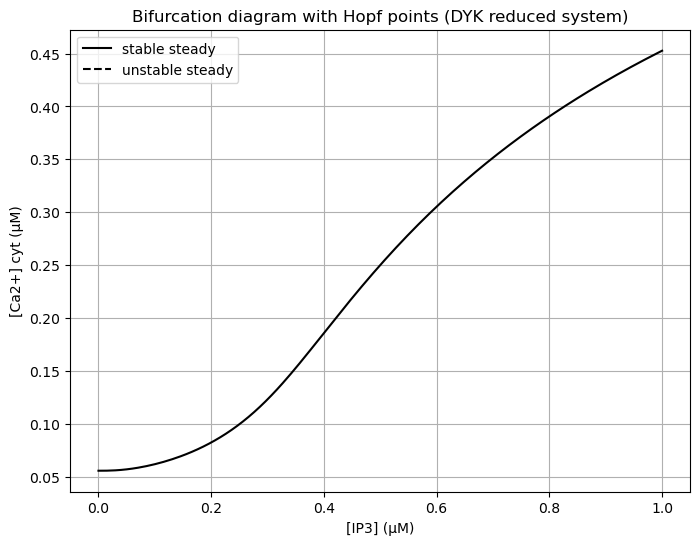

In [25]:
import numpy as np
import sympy as sp
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from numpy.linalg import eigvals
import matplotlib.pyplot as plt

# --------------------------
# Parameters (DYK 1992)
# --------------------------
c1 = 0.185
v1 = 6.0
v2 = 0.11
v3 = 0.9
k3 = 0.1
C0 = 2.0

a1, a2, a3, a4, a5 = 400.0, 0.2, 400.0, 0.2, 20.0
d1, d2, d3, d4, d5 = 0.13, 1.049, 0.9434, 0.1445, 0.08234


# C, x000, x010, x001, IP3 = sp.symbols('C x000 x010 x001 IP3')

# x110 = (IP3/d1)*x010
# x011 = (1 - x000 - x001 - x010)/(1 + IP3/d1)

# V1 = a4*(C*x000 - d4*x001)
# V2 = a4*(C*x010 - d4*x011)
# V3 = a5*(C*x000 - d5*x010)
# V4 = a5*(C*x001 - d5*x011)

# f000 = -V1 - V3
# f010 = V3 - V2
# f001 = V1 - V4
# Popen = ((C * IP3 * d2)/((C * IP3 + IP3 * d2 + d1*d2 + C*d3)*(C + d5)))**3
# CaER = (C0 - C)/c1
# J1 = c1*(v1*Popen + v2)*(CaER - C)
# J2 = v3*C**2/(C**2 + k3**2)
# fC = J1 - J2

# f = sp.Matrix([fC, f000, f010, f001])
# y = sp.Matrix([C, x000, x010, x001])

# J_sym = f.jacobian(y)

# jacobian_func = sp.lambdify((C, x000, x010, x001, IP3), J_sym, 'numpy')

def P_open(C, IP3):
    """

    """
    numerator = C * IP3 * d2
    denominator = (C * IP3 + IP3 * d2 + d1*d2 + C*d3)*(C + d5)
   
    return (numerator/denominator)**3

def jacobian(y, IP3, eps=1e-8):
    n = len(y)
    J = np.zeros((n,n))
    f0 = rhs(0,y,IP3)
    for i in range(n):
        y1 = y.copy()
        y1[i] += eps
        f1 = rhs(0,y1,IP3)
        J[:,i] = (f1 - f0)/eps
    return J

# def jacobian(y, IP3):
#     """
#     Analytic Jacobian at state y = [C, x000, x010, x001]
#     """
#     C_val, x000_val, x010_val, x001_val = y
#     return np.array(jacobian_func(C_val, x000_val, x010_val, x001_val, IP3), dtype=float)


def compute_x110(x010, IP3): return (IP3/d1) * x010
def compute_x011(x000, x001, x010, IP3): return (1-x000-x001-x010)/(1+IP3/d1)

def gating_rates(C, x000, x010, x001, IP3):
    x110 = compute_x110(x010, IP3)
    x011 = compute_x011(x000, x001, x010, IP3)
    V1 = a4*(C*x000 - d4*x001)
    V2 = a4*(C*x010 - d4*x011)
    V3 = a5*(C*x000 - d5*x010)
    V4 = a5*(C*x001 - d5*x011)
    dx000 = -V1 - V3
    dx010 = V3 - V2
    dx001 = V1 - V4
    return dx000, dx010, dx001, x110

def Jchan(C, x110, IP3):
    Popen = P_open(C, IP3)
    CaER = (C0 - C)/c1
    return c1*(v1*Popen + v2)*(CaER - C)

def Jpump(C): return v3*(C**2)/(C**2 + k3**2)

def rhs(t, y, IP3):
    C, x000, x010, x001 = y
    dx000, dx010, dx001, x110 = gating_rates(C,x000,x010,x001,IP3)
    dC = Jchan(C, x110, IP3) - Jpump(C)
    return np.array([dC, dx000, dx010, dx001])


def find_steady(IP3, guess=[0.1,0.9,0.05,0.05]):
    sol, _, ier, msg = fsolve(lambda y: rhs(0,y,IP3), guess, full_output=True)
    if ier!=1:
        raise RuntimeError(f"fsolve fail at IP3={IP3}: {msg}")
    return sol


IP3_vals = np.linspace(0.00,1.0,200)
steady_vals = []
stability = []
hopf_points = []

prev_real_parts = None


guess1=[0.1,0.9,0.05,0.05]
for ip in IP3_vals:
    y_ss = find_steady(ip, guess1)
    guess1 = y_ss
    steady_vals.append((ip,y_ss[0]))
    J = jacobian(y_ss, ip)
    eigs = eigvals(J)
    max_real = np.max(np.real(eigs))
    stability.append(max_real)
    if prev_real_parts is not None:
        if (prev_real_parts<0 and max_real>0) or (prev_real_parts>0 and max_real<0):
            hopf_points.append((ip,y_ss[0]))
    prev_real_parts = max_real

steady_vals = np.array(steady_vals)


plt.figure(figsize=(8,6))

eps = 1e-5  
stable_idx = [i for i,v in enumerate(stability) if v < -eps]
unstable_idx = [i for i,v in enumerate(stability) if v > eps]


plt.plot(steady_vals[stable_idx,0], steady_vals[stable_idx,1],'k-',label="stable steady")
plt.plot(steady_vals[unstable_idx,0], steady_vals[unstable_idx,1],'k--',label="unstable steady")

if hopf_points:
    hopf_points = np.array(hopf_points)
    plt.plot(hopf_points[:,0], hopf_points[:,1],'ro',label="Hopf")

plt.xlabel("[IP3] (µM)")
plt.ylabel("[Ca2+] cyt (µM)")
plt.title("Bifurcation diagram with Hopf points (DYK reduced system)")
plt.legend()
plt.grid(True)
plt.show()
